#Resnet Training

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
#from skimage.color import rgb2gray
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
#from torchvision import datasets, models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from PIL import Image
from sklearn.metrics import f1_score
plt.ion()   # interactive mode
from datetime import datetime
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [2]:
Train = torch.load('trainlist.pt')

In [3]:
Valid = torch.load('vallist.pt')

In [ ]:
Test = torch.load('Testlist.pt')

In [ ]:
#check dataset size
print(len(list(Valid)))
print(len(list(Train)))
print(len(list(Test)))

In [11]:
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": np.random.uniform(1e-4, 1e-1),
    "batch_size": np.random.choice([64]),
    "momentum": np.random.uniform( 0.1, 0.9)
}



In [6]:
#train_dataloader = DataLoader(Train, int(config["batch_size"]),
train_dataloader = DataLoader(Train, int(config["batch_size"]),
                        shuffle=True, num_workers=0)


In [7]:
val_dataloader = DataLoader(Valid, int(config["batch_size"]),
                        shuffle=True, num_workers=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#net = models.resnet18(config["l1"], config["l2"])
#net = models.resnet18(config["l1"], config["l2"])
#net = models.resnet34(config["l1"], config["l2"])


#net = models.resnet50()#(config["l1"], config["l2"])
#net = models.resnet101()#(config["l1"], config["l2"])
net = models.resnet152(config["l1"], config["l2"])
#net = net.cuda() if device else net
#net

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"],  weight_decay=config["weight_decay"])

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, config["lr"])


In [ ]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
pred_total =[]
target_total = []
f1_train_total = []
f1_val_total = []
total_step = len(train_dataloader)
since = time.time()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
 
        data_, target_ = data_.to(device), target_.to(device)
            
        # Compute prediction and loss
        outputs = net(data_.float())
        loss = criterion(outputs, target_.flatten().type(torch.LongTensor))
        
        
        # Backpropagation and param tunning
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        #STATS
        running_loss += loss.item()       
        _,pred = torch.max(outputs.float(), dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        #lr=config["lr"]
        #print(pred)
        #print(target_)
        f1 = f1_score(target_, pred, average='micro')
        #train_acc.append(100 * correct / total)
        f1_train_total.append(f1)
        #print(f1)
        pred_total.append(pred)
        target_total.append(target_)
        batch_size =int(config["batch_size"])
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], LR:[{}], batch_size:[{}], Loss: {:.4f}, f1: {:.4f},acc: {:.4f}'
                   .format(epoch, n_epochs, batch_idx, total_step,optimizer.param_groups[0]['lr'],batch_size, loss.item(),f1,(100 * correct/total)))
            dateTimeObj = datetime.now()
            print(dateTimeObj)
           #print(optimizer.param_groups[0]['lr'])
           # print(lr_scheduler.get_lr())
    #torch.save(pred_total, 'pred_total.pt')
    #torch.save(target_total, 'target_total.pt')
    scheduler.step()#to test

    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)

    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, f1: {(f1):.4f}')
    print(f'\correct: {correct:.4f}, total: {total:.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval() # switch to eval mode
        for data_t, target_t in (val_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t.float())
            loss_t = criterion(outputs_t.float(), target_t.flatten().type(torch.LongTensor))
            batch_loss += loss_t.item()
            
            _,pred_t = torch.max(outputs_t.float(), dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            #print(pred_t)
            #print(target_t)
            total_t += target_t.size(0)
            f1_val = f1_score(target_t, pred_t, average='micro')
            f1_val_total.append(f1_val)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(val_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation f1: {(f1_val):}\n') #{(100 * correct_t/total_t):.4f}\n')
        print(f'corret: {correct_t:.4f}, total: {total_t:.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        #save results
        f1_val_total.append(f1_val)
        #Pickling results
        with open("train_acc152.txt", "wb") as fp:   
                pickle.dump(train_acc, fp)
        with open("train_loss152.txt", "wb") as fp:   
                pickle.dump(train_loss, fp)
        with open("val_acc152101.txt", "wb") as fp:   
                pickle.dump(val_acc, fp)
        with open("val_loss152.txt", "wb") as fp:   
                pickle.dump(val_loss, fp)
        with open("train_f1152.txt", "wb") as fp:   
                pickle.dump(f1_train_total, fp)
        with open("val_f1152.txt", "wb") as fp:   
                pickle.dump(f1_val_total, fp) 
        #with open("train_pred_total.txt", "wb") as fp:   
        #        pickle.dump(train_acc, fp)
        #with open("train_target_total.txt", "wb") as fp:   
        #        pickle.dump(train_loss, fp)
        
        
        if network_learned:
            valid_loss_min = batch_loss
            print('Improvement-Detected, save-model')
            #torch.save(net.state_dict(), 'resnet52.pt')
            #torch.save(net.state_dict(), 'resnet32_1.pt')
            #torch.save(net.state_dict(), 'resnet50.pt')
            #torch.save(net.state_dict(), 'resnet101.pt')
            torch.save(net.state_dict(), 'resnet152.pt')

            
   
    net.train()# switch back to train mode
    #7min
    

In [12]:
with open("train_acc152.txt", "rb") as fp:   
        train_acc = pickle.load(fp)
with open("val_acc152.txt", "rb") as fp:   
        val_acc = pickle.load(fp) 

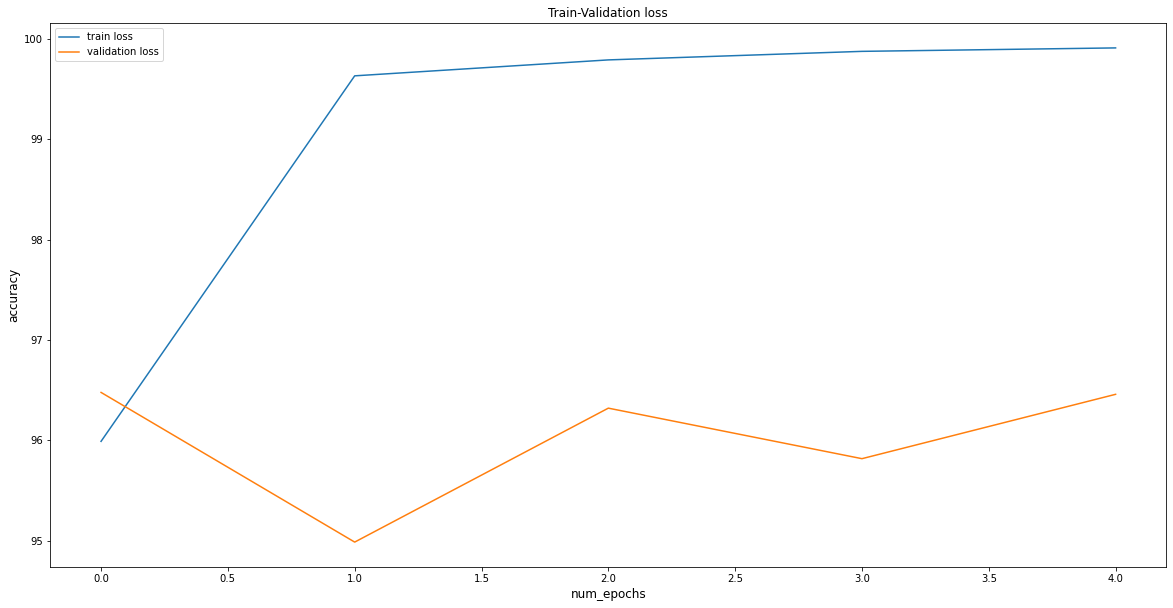

In [13]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation loss")
plt.plot(train_acc, label='train loss')
plt.plot(val_acc, label='validation loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [2]:
test = torch.load('testlist.pt')

In [14]:
config = {

    "lr": 0.01,
    "batch_size": np.random.choice([64]),
    "momentum": np.random.uniform( 0.8)
}


In [4]:
test_dataloader = DataLoader(test, int(config["batch_size"]),
                        shuffle=True, num_workers=0)

In [ ]:
net = models.resnet50()
net.load_state_dict(torch.load('resnet50.pt'))
net.eval()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"])

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=config["lr"])

In [ ]:
#Test for results
valid_loss_min = np.Inf
batch_loss = 0
total_t=0
correct_t=0
val_loss = []
val_acc = []
pred_total =[]
target_total = []
torchpred_total = torch.tensor([])
torchtarget_total = torch.tensor([])
with torch.no_grad():
    net.eval()
    for data_t, target_t in (test_dataloader):
        data_t, target_t = data_t.to(device), target_t.to(device)
        outputs_t = net(data_t.float())
        loss_t = criterion(outputs_t.float(), target_t.flatten().type(torch.LongTensor))
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t.float(), dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        total_t += target_t.size(0)
        pred_total.append(pred_t)
        target_total.append(target_t)
        print(pred_t)
        print(target_t)
        #torchpred_total = torch.cat(pred_t)
        #torchtarget_total = torch.cat(target_t)
        print(f'test loss: {np.mean(val_loss):.4f}, test acc: {(100 * correct_t/total_t):.4f}\n')
        print(f'corret: {correct_t:.4f}, total: {total_t:.4f}\n')
    val_acc.append(100 * correct_t/total_t)
    val_loss.append(batch_loss/len(test_dataloader))
    network_learned = batch_loss < valid_loss_min
    print(f'test loss: {np.mean(val_loss):.4f}, test acc: {(100 * correct_t/total_t):.4f}\n')
    print(f'corret: {correct_t:.4f}, total: {total_t:.4f}\n')
torch.save(pred_total, 'pred_total.pt')
torch.save(target_total, 'target_total.pt')
#torch.save(torchpred_total, 'pred_total.pt')
#torch.save(torchtarget_total, 'target_total.pt')